# 데이터 불러오기

In [6]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [7]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [8]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [10]:
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', SVC(random_state=0)),
])
params = {
'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
'clf__gamma': [0.0001, 0.001, 0.01, 0.1],
'clf__kernel': ['linear', 'sigmoid', 'rbf', 'poly'],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

# {'clf__C': 1000, 'clf__gamma': 0.0001}
# 0.7886769667892857

# {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
# 0.789041042569667

{'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
0.789041042569667


# 시각화

In [11]:
model = grid.best_estimator_['clf']
model.fit(X, y)

SVC(C=1000, gamma=0.0001, kernel='linear', random_state=0)

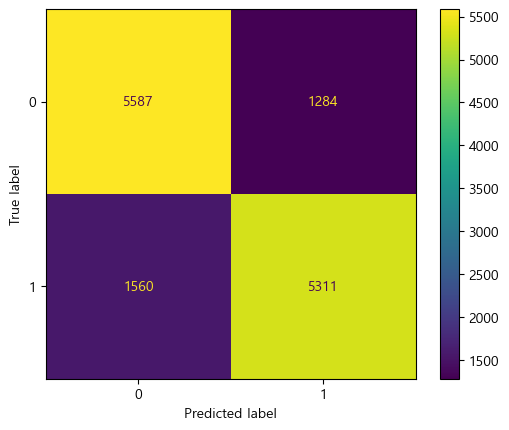

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, model.predict(X))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y, model.predict(X)))
#               precision    recall  f1-score   support

#            0       0.78      0.81      0.80      6871
#            1       0.81      0.77      0.79      6871

#     accuracy                           0.79     13742
#    macro avg       0.79      0.79      0.79     13742
# weighted avg       0.79      0.79      0.79     13742

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      6871
           1       0.81      0.77      0.79      6871

    accuracy                           0.79     13742
   macro avg       0.79      0.79      0.79     13742
weighted avg       0.79      0.79      0.79     13742



# 저장

In [14]:
result = pd.read_csv('../csv/model_results.csv')
result.head()

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784820,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.714525,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 3..."
4,Logit,0.787949,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."


In [15]:
if 'SVM' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('SVM')] = ['SVM', grid.best_score_, grid.best_params_]
else:
    result.loc[len(result.index)] = ['SVM', grid.best_score_, grid.best_params_]
result.head()

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784820,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.714525,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 3..."
4,Logit,0.787949,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."


In [16]:
result.to_csv('../csv/model_results.csv', index=None)

In [18]:
import joblib
joblib.dump(model, '../model/svm.model')
joblib.dump(model, '../model/svm.weight')

['../model/SVM.weight']